In [2]:
import Text_Importer as txtImp                                              # We import the necessary libraries and other scripts from the same project
from tkinter import filedialog
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import JV_Parameters_From_JV_Curve as JV_Par                                                    # First we import all the necessary scripts that we will need
import EQE_To_Jsc_Integrator as EtJ
import Jsc_From_EQE as JfE
import Small_Functions as sf
from statistics import mean
import Bgap_Finder as BgF
import numpy as np
import Active_layer_Classes as AlC


In [3]:

if __name__ == '__main__':

    # First we prompt the user to locate the file directory where all the JV and EQE files are located. Note that they must be named with a given convention. Material names for JV curve and EQE curve of the same material must be identical and the only difference
    # between these two files is that one must end with a _JV string and the other with an _EQE string.
    #File_Directory = filedialog.askdirectory(title='Select the directory with the EQE curves, Jv curves and solar data files', initialdir=os.getcwd(), mustexist=True)  # Ask for the directory where all the EQE and JV curve files are
    #print(File_Directory)
    File_Directory = 'C:/Users/mcasademont/Desktop/ENRIQUE P3HT data for rainbow analysis/ENRIQUE P3HT data for rainbow analysis'
    Available_files = os.listdir(File_Directory)                                                                                                                        # Save the available files within a list
    # print(*Available_files,sep='\n')                                                              # Print the available filenames for debugging purposes

    # We create a directory within the folder that has the curves where the figures will be saved
    Save_Directory = sf.Full_path_adder('Binary comparison figures', File_Directory)
    if not os.path.exists(Save_Directory):
        os.mkdir(Save_Directory)

    Active_layers = list()                                                                          # We initialize a list that will hold all the Active_layer classes

    # First we search for the solar irradiance spectrum file:
    Solar_data_found = False                                                                        # We set a flag so that if we do not find the solar data file we stop the whole process and raise an error
    for file in Available_files:
        # We loop through the files searching for the solar data file and save its data within the Solar_Data variable
        # The solar data file has to have the word Solar with the first letter capitalized to be acceptable
        if 'Solar' in file:                                                               # if the current file contains the word solar , we store the solar data it contains in the variable solar data
            Solar_Data = txtImp.import_txt(sf.Full_path_adder(file,File_Directory))         # We store the imported solar data on the Solar_Data variable
            Solar_data_found = True

    # If the solar data has not been found we raise an error
    if not Solar_data_found:
        raise Exception('The solar data has not been found, aborting process')


    # Here we loop through all the available files searching for the files that contain the substrings we are searching for. In this case we are searching for _JV and _EQE
    # The files have to end in _JV or in _EQE to be acceptable and if they are the same active layer material they should have exactly the same name except on the _JV or _EQE ending
    # IMPORTANT WARNING!!!! All materials that want to be processed need both a JV curve and an EQE file, otherwise they will be discarded
    for JV_file in Available_files:                                                            # We first loop through the available files in search for the JV_files
        if '_JV' in JV_file:                                                                        # If the file has the string _JV within its name it means it is a JV curve
            Material_name = JV_file.split('_JV', 1)[0]                                              # We extract the material_name by splitting the filename string and extracting the first column from the resulting list

            for EQE_file in Available_files:                                                        # Now we loop again through the files in search for its EQE file equivalent

                # if the file has the substring _EQE and the material name within the filename it means it's a match and we proceed to extract the data from both files
                if '_EQE' in EQE_file and Material_name in EQE_file:

                    # We extract the EQE curve values and the JV curve values and we store then in an Active_layer class that will be appended to the Active_layers list
                    EQE_curve = txtImp.import_txt(sf.Full_path_adder(EQE_file,File_Directory))      # We, momentarily, store the EQE_curve imported values within the EQE_curve variable
                    JV_curve = txtImp.import_txt(sf.Full_path_adder(JV_file, File_Directory))       # We, momentarily, store the JV_curve imported values within the JV_curve variable
                    Active_layers.append(AlC.Active_layer(Material_name, JV_curve, EQE_curve,Solar_Data))          # We append the Active_layer class with the current EQE_curve and JV_curve information as well as the material name within the Active_layers list


    Material_pairs = [[None for y in range(len(Active_layers))] for x in range(len(Active_layers))]         # We now create a 2D list that will hold the Active_layer_pair classes for each Active_layer material combination possible
    Total_figures = len(Active_layers)*len(Active_layers)-len(Active_layers)                                # We calculate the total number of figures that will be generated
    Saved_figures = 0                                                                                       # We also initialize a counter to keep track of the progress
    Timer_1 = sf.Timer()                                                                         # And finally we start a timer that will tell us the approximate time estimate and completion percentage

    for index_1, Active_layer_1 in enumerate(Active_layers):                                                # We loop through each available material
        for index_2, Active_layer_2 in enumerate(Active_layers):                                            # And for each available material we loop again comparing it to all the other available materials
            if index_1 == index_2:                                                                          # If the indexes are the same it means they are the same active material combination so we 'pass' and do not compare them
                pass
            else:                                                                                           # If, otherwise the two indices are not the same we proceed to compare them and plot them
                Material_pairs[index_1][index_2] = AlC.Active_layer_Pair(Active_layer_1,Active_layer_2,Solar_Data)      # We store the current material combination within the Material_pairs list as n Active_layer_pair class with the active layers to compare as attributes, and of course the solar data


<function matplotlib.pyplot.show(close=None, block=None)>

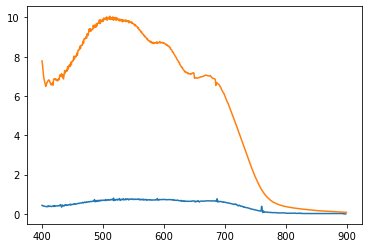

In [65]:

#Now that we have all the data of the different pairs stored in Material_pairs we can start culating the EQE. As a first aproximation, we will say that the derivative of Jsc
#with respect to the cutting wavelength is equal to the EQE at the cutting wavelength multiplied by the solar irradiance at that wavelength. 

index_1 = 2
index_2 = 3
Active_layer_1 = Active_layers[index_1]
Jsc_divWL_slope = np.gradient(np.array(Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1))
Solar_data_nparray = np.array(Solar_Data)
EQE_calculated = np.zeros((len(Jsc_divWL_slope)))
wl_list = np.array(Material_pairs[index_1][index_2].Dividing_wavelength_list)
for i in range(len(Jsc_divWL_slope)):
    actual_wavelength = wl_list[i]
    Solar_Data_actualwl_index = np.where(Solar_data_nparray[:,0] == wl_list[i]) 
    EQE_calculated[i] = 100 *Active_layer_1.Voc * Active_layer_1.Integrated_Jsc_correction_factor * Jsc_divWL_slope[i]/Solar_data_nparray[Solar_Data_actualwl_index,1]


plt.plot(wl_list, EQE_calculated)
plt.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), sf.Extract_Column(Active_layer_1.EQE_curve, 1))
#plt.xlim(300,400)
#plt.ylim(0,10)
plt.show

In [10]:
print(Solar_data_nparray)

[[2.800e+02 2.540e-26]
 [2.805e+02 1.090e-24]
 [2.810e+02 6.130e-24]
 ...
 [3.990e+03 7.390e-03]
 [3.995e+03 7.230e-03]
 [4.000e+03 7.120e-03]]
